# DataCleaning

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Common-funcs" data-toc-modified-id="Common-funcs-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Common funcs</a></span></li><li><span><a href="#Categorical-data-problems" data-toc-modified-id="Categorical-data-problems-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Categorical data problems</a></span></li><li><span><a href="#Uniform-dates" data-toc-modified-id="Uniform-dates-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Uniform dates</a></span></li><li><span><a href="#Missing-data" data-toc-modified-id="Missing-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Missing data</a></span></li><li><span><a href="#字串相似度" data-toc-modified-id="字串相似度-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>字串相似度</a></span></li><li><span><a href="#Generating-pairs" data-toc-modified-id="Generating-pairs-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Generating pairs</a></span></li></ul></div>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jupyterthemes.jtplot as jtplot
%matplotlib inline
jtplot.style(theme='onedork')

## Common funcs
- `df.col.astype`
- Set values
    - `df.loc[df.col > 27, col] = 27`
- duplicates
    - `df.duplicated(subset=['co1', col2], keep=)`
        - return bool Series，找重複
        - `keep{‘first’, ‘last’, False}, default ‘first’`
            - 第一次出現不return, 最後一次出現不return, 全return
    - `df.drop_duplicates(subset=['co1', col2], keep=, inplace=)`
        - 丟掉重複
- replace value
    - df.S.replace, df.replace
        - take a dict agg
- missing

In [3]:
ride_sharing = pd.read_csv('ride_sharing_new.csv', index_col=0)
# ride_sharing.info()
ride_sharing['duration'].head(3)

0    12 minutes
1    24 minutes
2     8 minutes
Name: duration, dtype: object

In [4]:
ride_sharing['duration'] = ride_sharing['duration']\
                            .str.strip('minutes')\
                            .astype(int)
ride_sharing['duration'].head(3)

0    12
1    24
2     8
Name: duration, dtype: int64

In [5]:
sub=['bike_id', 'user_birth_year']
# Find duplicates
duplicates = ride_sharing.duplicated(sub, keep=False)

# Sort your duplicated rides
duplicated_id = ride_sharing[duplicates].sort_values(sub).reset_index(drop=True)

duplicated_id[sub].head(5)

,bike_id,user_birth_year
0,27,1971
1,27,1971
2,27,1988
3,27,1988
4,27,1989


In [6]:
# Drop complete duplicates from ride_sharing
ride_dup = ride_sharing.drop_duplicates()
def round_1(x):
    return round(np.mean(x),1)
    
# Create statistics dictionary for aggregation function
statistics = {'user_birth_year': 'min', 'duration':round_1 }

# # Group by ride_id and compute new statistics
ride_unique = ride_sharing.groupby('bike_id').agg(statistics).reset_index()

# Find duplicated values again
duplicates = ride_unique.duplicated(subset = 'bike_id', keep = False)
duplicated_rides = ride_unique[duplicates == True]

# Assert duplicates are processed
assert duplicated_rides.shape[0] == 0

## Categorical data problems

In [25]:
airlines = pd.read_csv('airlines_final.csv', index_col=0)
airlines.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2477 entries, 0 to 2808
Data columns (total 12 columns):
id               2477 non-null int64
day              2477 non-null object
airline          2477 non-null object
destination      2477 non-null object
dest_region      2477 non-null object
dest_size        2477 non-null object
boarding_area    2477 non-null object
dept_time        2477 non-null object
wait_min         2477 non-null float64
cleanliness      2477 non-null object
safety           2477 non-null object
satisfaction     2477 non-null object
dtypes: float64(1), int64(1), object(10)
memory usage: 251.6+ KB


In [15]:

airlines['cleanliness'].unique()

array(['Clean', 'Average', 'Somewhat clean', 'Somewhat dirty', 'Dirty'],
      dtype=object)

In [22]:
# Find the cleanliness category in airlines not in categories
cat_clean = set(airlines['cleanliness']).difference(airlines['cleanliness'].unique())

# Find rows with that category
cat_clean_rows = airlines['cleanliness'].isin(cat_clean)

# # Print rows with inconsistent category
# print(airlines[cat_clean_rows])

# # Print rows with consistent categories only
# print(airlines[~cat_clean_rows])

In [47]:
# Create ranges for categories
label_ranges = [0, 60, 180, np.inf]
label_names = ['short', 'medium', 'long']

# Create wait_type column
airlines['wait_type'] = pd.cut(airlines['wait_min'],
                               bins = label_ranges, 
                                labels = label_names)

print(airlines['wait_min'].quantile([0.33, 0.66]))
# Quantile-based  Interval = 1/q
airlines['wait_type2'] = pd.qcut(airlines['wait_min'],
                               q = 3, 
                                labels = label_names)

# Create mappings and replace
mappings = {'Monday':'weekday', 'Tuesday':'weekday', 'Wednesday': 'weekday', 
            'Thursday': 'weekday', 'Friday': 'weekday', 
            'Saturday': 'weekend', 'Sunday': 'weekend'}

airlines['day_week'] = airlines['day'].replace(mappings)
# airlines[airlines.wait_min>=169][['wait_min','wait_type', 'wait_type2']]
airlines[['wait_min','wait_type', 'wait_type2']].head()

0.33    120.0
0.66    170.0
Name: wait_min, dtype: float64


,wait_min,wait_type,wait_type2
0,115.0,medium,short
1,135.0,medium,medium
2,70.0,medium,short
3,190.0,long,long
4,559.0,long,long


In [49]:
# Store length of each row in destination column
destination_length = airlines.destination.str.len()

# Find rows in airlines where length > 40
airlines_ = airlines[destination_length > 15]

# Assert minimum survey_response length is > 40
assert airlines_.destination.str.len().min() > 15

# Print new survey_response column
airlines_['destination'].head()

1        SAN JOSE DEL CABO
15    MINNEAPOLIS-ST. PAUL
32        DALLAS-FT. WORTH
71    WASHINGTON DC-DULLES
75        DALLAS-FT. WORTH
Name: destination, dtype: object

## Uniform dates

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt
import random
import numpy as np
import datetime as dt

In [119]:
banking = pd.read_csv('banking_dirty.csv', index_col=0)
banking['acct_cur'] = np.random.randint(0,2, size=len(banking))
banking.info()
banking.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 99
Data columns (total 12 columns):
cust_id             100 non-null object
birth_date          100 non-null object
Age                 100 non-null int64
acct_amount         100 non-null float64
inv_amount          100 non-null int64
fund_A              100 non-null float64
fund_B              100 non-null float64
fund_C              100 non-null float64
fund_D              100 non-null float64
account_opened      100 non-null object
last_transaction    100 non-null object
acct_cur            100 non-null int64
dtypes: float64(5), int64(3), object(4)
memory usage: 10.2+ KB


,cust_id,birth_date,Age,acct_amount,inv_amount,fund_A,fund_B,fund_C,fund_D,account_opened,last_transaction,acct_cur
0,870A9281,1962-06-09,58,63523.31,51295,30105.0,4138.0,1420.0,15632.0,02-09-18,22-02-19,1
1,166B05B0,1962-12-16,58,38175.46,15050,4995.0,938.0,6696.0,2421.0,28-02-19,31-10-18,1
2,BFC13E88,1990-09-12,34,59863.77,24567,10323.0,4590.0,8469.0,1185.0,25-04-18,02-04-18,0
3,F2158F66,1985-11-03,35,84132.10,23712,3908.0,492.0,6482.0,12830.0,07-11-17,08-11-18,1
4,7A73F334,1990-05-17,30,120512.00,93230,12158.4,51281.0,13434.0,18383.0,14-05-18,19-07-18,0


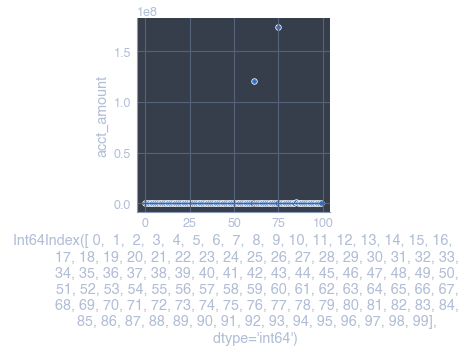

In [120]:
sns.relplot(y= 'acct_amount',
            x= banking.index,
            data =banking, kind = 'scatter')
plt.show()

In [121]:
# Find values of acct_cur that are equal to 1
acct_eu = banking['acct_cur'] == 1

# Convert acct_amount where it is in euro to dollars
banking.loc[acct_eu, 'acct_amount'] = \
                        banking.loc[acct_eu, 'acct_amount'] * 1.1

# Unify acct_cur column by changing 1 to 0
banking.loc[acct_eu, 'acct_cur'] = 0

# Print unique values of acct_cur
assert banking['acct_cur'].unique() == 0

In [122]:
# Print the header of account_opend
print(banking['account_opened'].head())

# Convert account_opened to datetime
banking['account_opened'] = pd.to_datetime(banking['account_opened'],
                                           # Infer datetime format
                                           infer_datetime_format = True,
                                           # Return missing value for error
                                           errors = 'coerce') 

# Get year of account opened
banking['acct_year'] = banking['account_opened'].dt.strftime('%Y')

# Print acct_year
banking['acct_year'].head()

0    02-09-18
1    28-02-19
2    25-04-18
3    07-11-17
4    14-05-18
Name: account_opened, dtype: object


0    2018
1    2019
2    2018
3    2017
4    2018
Name: acct_year, dtype: object

In [123]:
# Store fund columns to sum against
fund_columns = ['fund_A', 'fund_B', 'fund_C', 'fund_D']

# Find rows where fund_columns row sum == inv_amount
inv_equ = banking[fund_columns].sum(axis=1).agg(round) == banking.inv_amount

# Store consistent and inconsistent data
consistent_inv = banking[inv_equ]
inconsistent_inv = banking[~inv_equ]

# Store consistent and inconsistent data
print("Number of inconsistent investments: ", inconsistent_inv.shape[0])

Number of inconsistent investments:  8


In [128]:
banking['birth_date'] = pd.to_datetime(banking['birth_date'],
                                           # Infer datetime format
                                           infer_datetime_format = True,
                                           # Return missing value for error
                                           errors = 'coerce') 
# Store today's date and find ages
today = dt.date.today()
ages_manual = today.year - banking.birth_date.dt.year



# Find rows where age column == ages_manual
age_equ = banking.Age == ages_manual

# Store consistent and inconsistent data
consistent_ages = banking[age_equ]
inconsistent_ages = banking[~age_equ]

# Store consistent and inconsistent data
print("Number of inconsistent ages: ", inconsistent_ages.shape[0])

Number of inconsistent ages:  8


## Missing data

In [130]:
import missingno as msno

cust_id             0
birth_date          0
Age                 0
acct_amount         0
inv_amount          0
fund_A              0
fund_B              0
fund_C              0
fund_D              0
account_opened      0
last_transaction    0
acct_cur            0
acct_year           0
dtype: int64


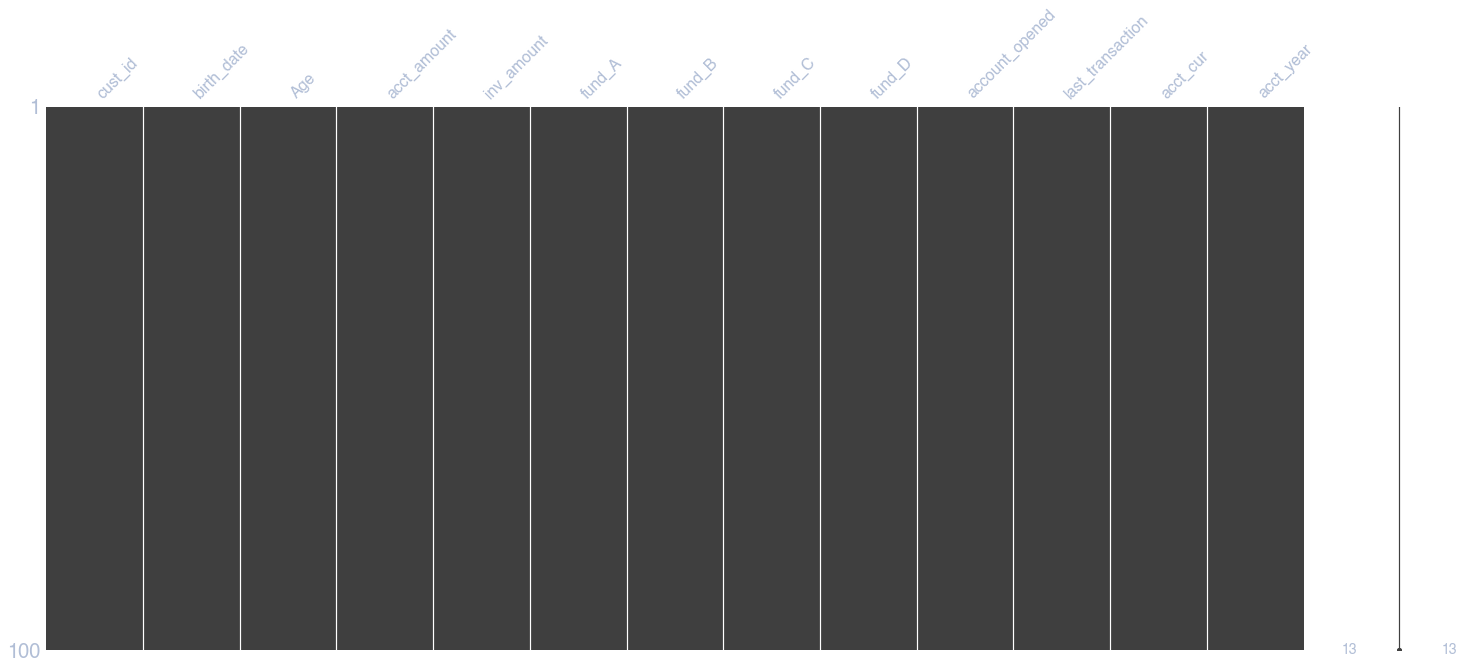

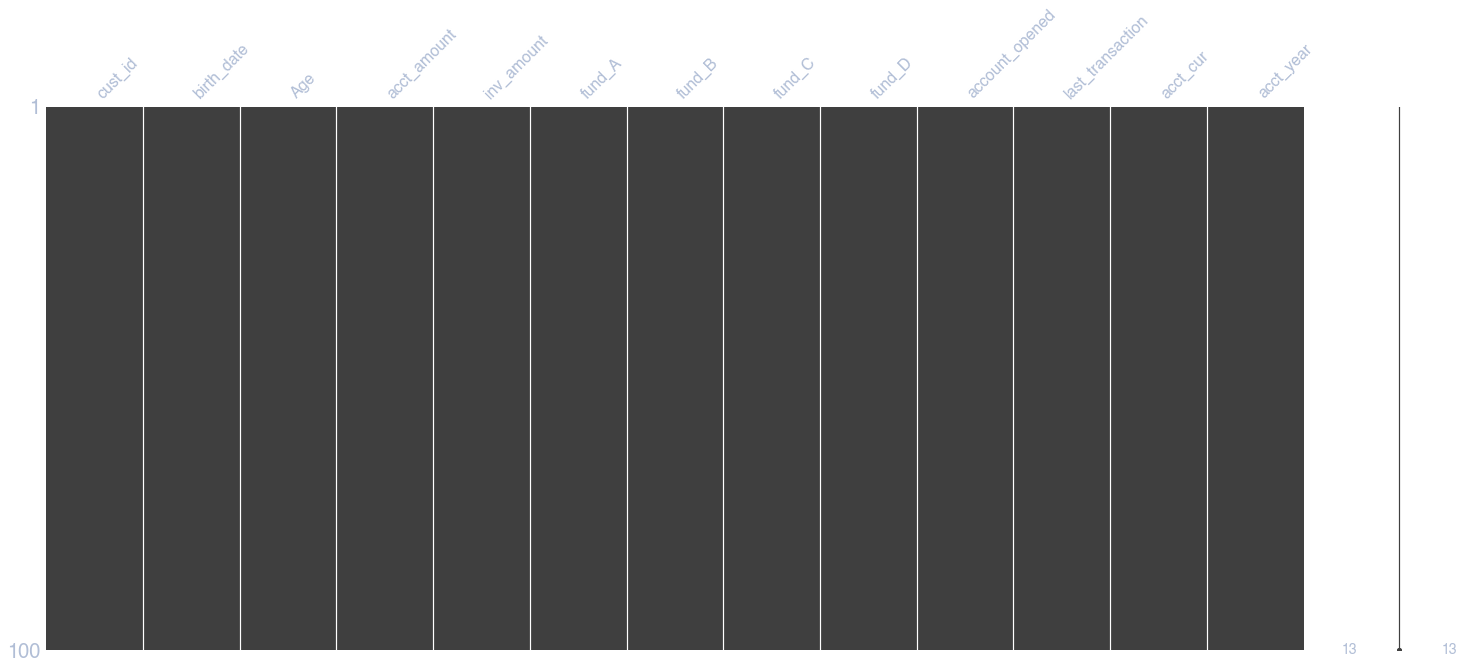

In [132]:
# Print number of missing values in banking
print(banking.isna().sum())

# Visualize missingness matrix
msno.matrix(banking)
plt.show()

# Isolate missing and non missing values of inv_amount
missing_investors = banking[banking['inv_amount'].isna()]
investors = banking[~banking['inv_amount'].isna()]

# Sort banking by age and visualize
banking_sorted = banking.sort_values('Age')
msno.matrix(banking_sorted)
plt.show()

In [133]:
# Drop missing values of cust_id
banking_fullid = banking.dropna(subset = ['cust_id'])

# Compute estimated acct_amount
acct_imp = banking_fullid['inv_amount'] * 5

# Impute missing acct_amount with corresponding acct_imp
banking_imputed = banking_fullid.fillna({'acct_amount':acct_imp})

# Print number of missing values
print(banking_imputed.isna().sum())

cust_id             0
birth_date          0
Age                 0
acct_amount         0
inv_amount          0
fund_A              0
fund_B              0
fund_C              0
fund_D              0
account_opened      0
last_transaction    0
acct_cur            0
acct_year           0
dtype: int64


## 字串相似度

In [136]:
from fuzzywuzzy import process as fuzpro

/Users/ellick/anaconda3/envs/datacamp/lib/python3.7/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [153]:
restaurants = pd.read_csv('restaurants_L2_dirty.csv', index_col=0)
restaurants.head()
restaurants.city.unique()

array(['la', 'hollywood', 'pasadena', 'los angeles', 'new york',
       'studio city', 'venice', 'santa monica', 'mar vista',
       'beverly hills', 'w. hollywood', 'encino', 'st. boyle hts .',
       'westlake village', 'westwood', 'west la', 'chinatown',
       'monterey park', 'rancho park', 'redondo beach', 'long beach',
       'marina del rey', 'culver city', 'burbank', 'century city',
       'malibu', 'seal beach', 'northridge', 'st. hermosa beach'],
      dtype=object)

In [156]:
fuzpro.extract('hollywood', restaurants.city.unique(), 
                 limit = len(restaurants))

[('hollywood', 100),
 ('w. hollywood', 95),
 ('westwood', 47),
 ('la', 45),
 ('chinatown', 33),
 ('westlake village', 28),
 ('beverly hills', 27),
 ('redondo beach', 26),
 ('marina del rey', 26),
 ('west la', 24),
 ('northridge', 21),
 ('los angeles', 20),
 ('studio city', 20),
 ('rancho park', 20),
 ('long beach', 20),
 ('culver city', 20),
 ('seal beach', 20),
 ('st. hermosa beach', 20),
 ('monterey park', 18),
 ('encino', 15),
 ('malibu', 15),
 ('pasadena', 12),
 ('new york', 12),
 ('santa monica', 10),
 ('st. boyle hts .', 10),
 ('century city', 10),
 ('venice', 0),
 ('mar vista', 0),
 ('burbank', 0)]

In [146]:
categories =  ['asian', 'american', 'italian']

In [149]:
# For each correct cuisine_type in categories
for cuisine in categories:
    # Find matches in cuisine_type of restaurants
    matches = fuzpro.extract(cuisine, restaurants['type'], 
                 limit = len(restaurants))
  # For each possible_match with similarity score >= 80
    for possible_match in matches:
        if possible_match[1] >= 80:
      # Find matching cuisine type
            matching_cuisine = restaurants['type'] == possible_match[0]
            restaurants.loc[matching_cuisine, 'type'] = cuisine

# Print unique values to confirm mapping
print(restaurants['type'].unique())

['american' 'californian' 'japanese' 'cajun/creole' 'hot dogs' 'diners'
 'delis' 'hamburgers' 'seafood' 'italian' 'coffee shops' 'russian'
 'steakhouses' 'mexican/tex-mex' 'noodle shops' 'middle eastern' 'asian'
 'vietnamese' 'health food' 'pacific new wave' 'indonesian' 'eclectic'
 'chicken' 'fast food' 'southern/soul' 'coffeebar' 'continental'
 'french ( new )' 'desserts' 'chinese' 'pizza']


## Generating pairs

In [157]:
# # Create an indexer and object and find possible pairs
# indexer = recordlinkage.Index()

# # Block pairing on cuisine_type
# indexer.block('cuisine_type')

# # Generate pairs
# pairs = indexer.index(restaurants, restaurants_new)

In [158]:
# # Create a comparison object
# comp_cl = recordlinkage.Compare()

# # Find exact matches on city, cuisine_types - 
# comp_cl.exact('city', 'city', label='city')
# comp_cl.exact('cuisine_type', 'cuisine_type', label='cuisine_type')

# # Find similar matches of rest_name
# comp_cl.string('rest_name', 'rest_name', label='name', threshold = 0.8) 

# # Get potential matches and print
# potential_matches = comp_cl.compute(pairs, restaurants, restaurants_new)
# print(potential_matches)

In [159]:
# # Isolate potential matches with row sum >=3
# matches = potential_matches[potential_matches.sum(axis=1) >= 3]

# # Get values of second column index of matches
# matching_indices = matches.index.get_level_values(1)

# # Subset restaurants_new based on non-duplicate values
# non_dup = restaurants_new[~restaurants_new.index.isin(matching_indices)]

# # Append non_dup to restaurants
# full_restaurants = restaurants.append(non_dup)
# print(full_restaurants)